<a href="https://colab.research.google.com/github/deRockerTom/Account_Manager/blob/main/stegano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O image.png "http://r0k.us/graphics/kodak/kodak/kodim07.png"
!wget -O data.txt "https://pastebin.com/raw/fvuinc16"

--2022-06-22 17:10:01--  http://r0k.us/graphics/kodak/kodak/kodim07.png
Resolving r0k.us (r0k.us)... 174.127.119.148
Connecting to r0k.us (r0k.us)|174.127.119.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 566322 (553K) [image/png]
Saving to: ‘image.png’

image.png           100%[===================>] 553.05K  1.80MB/s    in 0.3s    

2022-06-22 17:10:02 (1.80 MB/s) - ‘image.png’ saved [566322/566322]

--2022-06-22 17:10:02--  https://pastebin.com/raw/fvuinc16
Resolving pastebin.com (pastebin.com)... 104.20.67.143, 104.20.68.143, 172.67.34.170, ...
Connecting to pastebin.com (pastebin.com)|104.20.67.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘data.txt’

data.txt                [ <=>                ]   2.44K  --.-KB/s    in 0s      

2022-06-22 17:10:03 (30.7 MB/s) - ‘data.txt’ saved [2499]



In [4]:
from PIL import Image

imgName = "image.png"
imgSecretName = "imgWithSecret.png"

dataSecretName = "data.txt"
dataRecoverName = "dataOut.txt"

In [5]:
def getDataBits(data):
  bits = []
  for byte in data:
    for b in range(0,8):
      bits.append((byte >> b) & 0b1)
  
  return bits

In [10]:
def putDataInsideImage(im, data):
  dataBits = getDataBits(data)

  maxX = im.size[0] # width of the image
  maxY = im.size[1] # height of the image
  maxC = len(im.getpixel((0,0))) # number of channels in the image

  x = 0 # x coordinate of the pixel
  y = 0 # y coordinate of the pixel
  c = 0 # color channel of the pixel

  for bit in dataBits:
    color = list(im.getpixel((x,y)))
    color[c] = (color[c] & (~0b1)) | bit;
    im.putpixel((x,y), tuple(color)) 

    c = c + 1 # we first iterate through the color channel
    if c >= maxC:
      c = 0
      x = x + 1 # then through the x coordinate
      if x >= maxX:
        x = 0
        y = y + 1 # and finally through the y coordinate
  if y >= maxY:
    print("Not enough pixels!")
    return
	

        # knowing the order in which we save the bits is important when recovering the data from the image

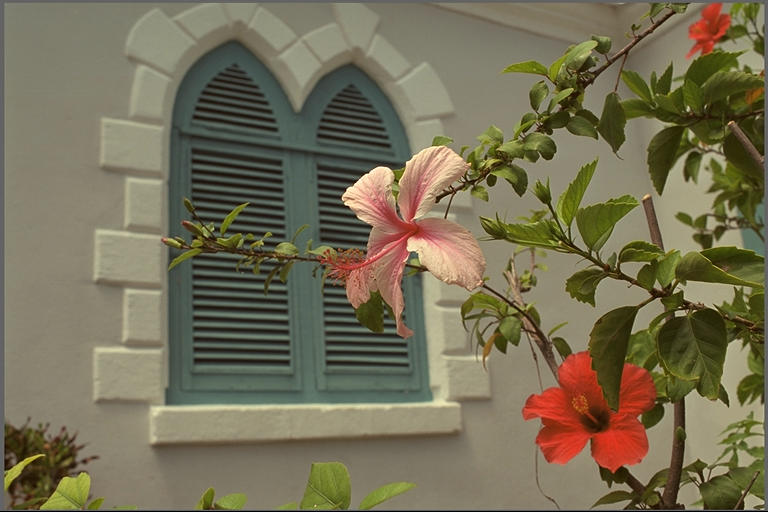

In [11]:
im = Image.open(imgName)
im

In [12]:
with open(dataSecretName, "rb") as dataFile: # Note that we open in binary mode
  secretData = dataFile.read()

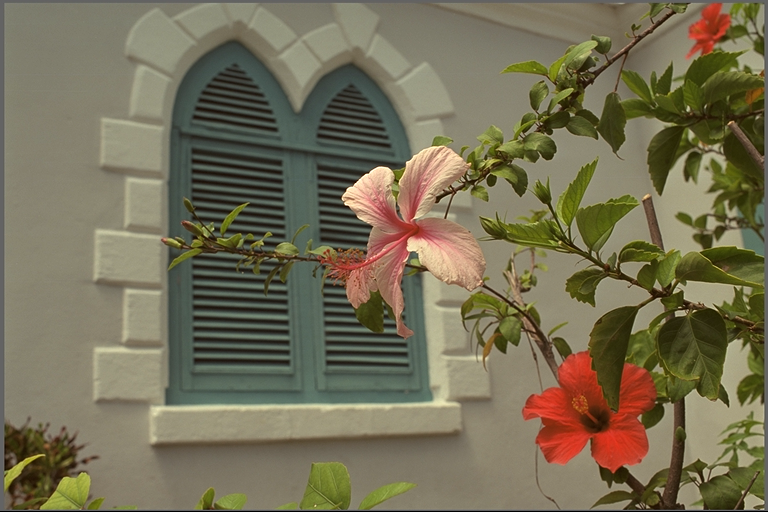

In [13]:
putDataInsideImage(im, secretData)
im.save(imgSecretName)
im

In [14]:
def getBitsFromImage(im):
  bits = []

  maxC = len(im.getpixel((0,0)))
  for y in range(0, im.size[1]):
    for x in range(0, im.size[0]):
      for c in range(0, maxC):
        bits.append(im.getpixel((x,y))(c) & 0b1)

  return bits

In [15]:
def getBitsFromImage(im, maxBits = 0):
  bits = []

  maxC = len(im.getpixel((0,0)))
  for y in range(0, im.size[1]):
    for x in range(0, im.size[0]):
      for c in range(0, maxC):
        bits.append(im.getpixel((x,y))[c] & 0b1)
        if maxBits is not 0 and len(bits) >= maxBits:
          return bits

  return bits

In [17]:
def bitsToBytes(dataBits):
  dataBytes = []
  for i in range(0, len(dataBits), 8):
    if i+7 >= len(dataBits):
      break
    
    currByte = 0
    for b in range(0, 8):
      currByte = currByte | (dataBits[i + b] << b)

    dataBytes.append(currByte)

  return(bytes(dataBytes))

In [18]:
def getDataFromImage(im):
  dataBits = getBitsFromImage(im)
  return bitsToBytes(dataBits)

In [19]:
imO = Image.open(imgSecretName)
with open(dataRecoverName, "wb") as dataFile: # Note that we open in binary mode
  dataFile.write(getDataFromImage(imO))

In [20]:
import struct
def putDataInsideImageWithSize(im, data):
  data = list(data)
  data[0:0] = struct.pack("=L", len(data)) # insert 4 bytes at the start of the data that specify the ammount of data in number of bytes, the pack function takes the number and returns the bytes representing the number
  putDataInsideImage(im, bytes(data))

In [21]:
im = Image.open(imgName)
with open(dataSecretName, "rb") as dataFile: # Note that we open in binary mode
  secretData = dataFile.read()
putDataInsideImageWithSize(im, secretData)
im.save(imgSecretName)

In [22]:
def getDataFromImageWithSize(im):
  dataSizeBits = getBitsFromImage(im, 4*8)
  dataSize = struct.unpack("=L", bitsToBytes(dataSizeBits))[0]
  dataBits = getBitsFromImage(im, 4*8 + dataSize*8) 
  return bitsToBytes(dataBits)[4:]

In [23]:
imO = Image.open(imgSecretName)
with open(dataRecoverName, "wb") as dataFile: # Note that we open in binary mode
  dataFile.write(getDataFromImageWithSize(imO))